In [39]:
import pandas as pd
import os
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

from datetime import datetime
import time

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score, f1_score, recall_score, precision_score

import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
def get_model_metrics(test_data, model, model_name):
    '''''''''
    Get binary classification metrics for a given model and saves the results to local directory
    '''''''''
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'
    
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    predicted_probs = model.predict_proba(test_data[0])
    predicted_probs = predicted_probs[:, 1]
    true_labels = test_data[1]
    predicted_labels = model.predict(test_data[0])

    # determine the best threshold
    thresholds = np.linspace(0, 1, 100)
    best_f1 = 0
    best_threshold = 0.5
    for thresh in thresholds:
        predicted_labels = [1 if p > thresh else 0 for p in predicted_probs]
        f1 = f1_score(true_labels, predicted_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh

    print(f"Best threshold: {best_threshold:.2f} with F1-score: {best_f1:.2f}")
    
    # recalculate predictions with the best threshold
    final_predicted_labels = [1 if p > best_threshold else 0 for p in predicted_probs]
    
    # Confusion Matrix
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Purples",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)

    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # ROC AUC
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2) 

    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)

    # plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [41]:
# Set the path to your data folders
data_folder = "../../Data/CIR/cropped_images"
train_folder = os.path.join(data_folder, "cropped_train")
test_folder = os.path.join(data_folder, "cropped_test")
validation_folder = os.path.join(data_folder, "cropped_validation")

## IMAGE AUGMENTATION

In [42]:
from imgaug import augmenters as iaa

In [43]:
# less aggressive image aug
aug = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip with 50% probability
    iaa.Flipud(0.5),  # Vertical flip with 50% probability
    iaa.Multiply((0.8, 1.2)),  # Random brightness adjustment
    iaa.LinearContrast((0.8, 1.2)),  # Random contrast adjustment
])

In [44]:
def augment_images(images):
    # Convert to numpy arrays if they are in a different format
    images_np = np.array(images)
    images_aug = aug.augment_images(images_np)
    return images_aug

## Extract GLCM features

In [45]:
from sklearn.preprocessing import StandardScaler

In [46]:
def extract_features(image_path):
    image = cv2.imread(image_path, 0)  # Read the image in grayscale
    if image is None or image.size == 0:
        raise ValueError(f"Image at {image_path} could not be loaded")

    resized_img = cv2.resize(image, (128, 64))
    
    props = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
    features = []

    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    glcm = graycomatrix(resized_img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    for prop in props:
        glcm_prop = graycoprops(glcm, prop)
        features.extend(glcm_prop.flatten())

    return features

def extract_features_train(image):
    resized_img = cv2.resize(image, (128, 64))
    
    props = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
    features = []

    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    glcm = graycomatrix(resized_img, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    for prop in props:
        glcm_prop = graycoprops(glcm, prop)
        features.extend(glcm_prop.flatten())

    return features

def normalize_features(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)

def load_data(folder):
    data = []
    labels = []

    for subfolder in os.listdir(folder):
        if subfolder != '.DS_Store':
            subfolder_path = os.path.join(folder, subfolder)
            for image_file in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_file)
                try:
                    features = extract_features(image_path)
                    data.append(features)
                    labels.append(subfolder)
                except Exception as e:
                    print(f"Error processing file {image_path}: {e}")
                    continue

    normalized_data = normalize_features(np.array(data))
    return normalized_data, labels

def load_data_train(folder, augmentations_per_image=1):
    data = []
    labels = []

    for subfolder in os.listdir(folder):
        if subfolder != '.DS_Store':
            subfolder_path = os.path.join(folder, subfolder)
            for image_file in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_file)
                try:
                    image = cv2.imread(image_path, 0)
                    if image is None or image.size == 0:
                        continue

                    original_features = extract_features_train(image)
                    data.append(original_features)
                    labels.append(subfolder)

                    for _ in range(augmentations_per_image):
                        image_aug = aug.augment_image(image)
                        augmented_features = extract_features_train(image_aug)
                        data.append(augmented_features)
                        labels.append(subfolder)

                except Exception as e:
                    print(f"Error processing file {image_path}: {e}")
                    continue

    return np.array(data), labels

# With Image Augmentation applied

In [47]:
X_train, y_train = load_data_train(train_folder, augmentations_per_image=3)
X_validation, y_validation = load_data(validation_folder)
X_test, y_test = load_data(test_folder)

In [48]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform your string labels to numerical labels
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
y_validation = label_encoder.fit_transform(y_validation)

In [49]:
# Merge X_test and X_validation
X_test = np.vstack((X_test, X_validation))
y_test = np.concatenate((y_test, y_validation))

In [50]:
# save data to upload to colab for later model tuning
np.savetxt("X_train_CIR.csv", X_train, delimiter=",")
np.savetxt("X_test_CIR.csv", X_test, delimiter=",")
np.savetxt("y_train_CIR.csv", y_train, delimiter=",")
np.savetxt("y_test_CIR.csv", y_test, delimiter=",")

In [13]:
# Extract class weights
from sklearn.utils.class_weight import compute_class_weight

# Convert the labels to a NumPy array
labels = np.array(y_train)

total_samples = len(labels)
class_labels, class_counts = np.unique(labels, return_counts=True)
#class_weights = total_samples / (len(class_labels) * class_counts)
class_weights = [1 - class_counts[0] / total_samples, 1 - class_counts[1] / total_samples]

# Create a dictionary for class weights
class_weights_dict = dict(zip(class_labels, class_weights))

#new_labels = {'healthy': 0, 'unhealthy': 1}

# Create a new dictionary with the renamed keys
#class_weights = {new_labels[key]: value for key, value in class_weights_dict.items()}

In [14]:
class_weights_dict

{0: 0.059920106524633865, 1: 0.9400798934753661}

In [15]:
sample_weights = [class_weights[label] for label in y_train]

## SVC

In [16]:
# Train a classifier (SVM in this case)
classifier = SVC(kernel='linear', C=1.0, random_state=42, probability=True, class_weight=class_weights_dict)
classifier.fit(X_train, y_train)

SVC(class_weight={0: 0.059920106524633865, 1: 0.9400798934753661},
    kernel='linear', probability=True, random_state=42)

Best threshold: 0.04 with F1-score: 0.17


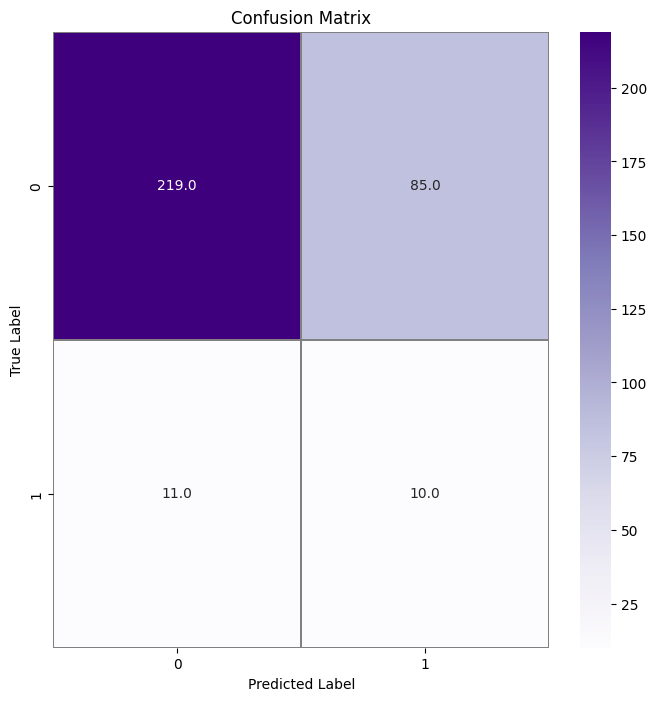

              precision    recall  f1-score   support

           0       0.95      0.72      0.82       304
           1       0.11      0.48      0.17        21

    accuracy                           0.70       325
   macro avg       0.53      0.60      0.50       325
weighted avg       0.90      0.70      0.78       325

    Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity   
0  CIR-SVC-AUG  0.62                     0.17       0.7         0.48  \

   Specificity   PPV   NPV  PLR   NLR  
0         0.72  0.11  0.95  1.7  0.73  


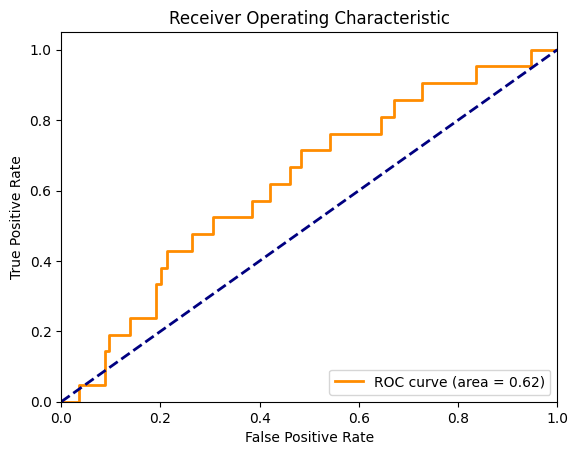

In [17]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name='CIR-SVC-AUG')

In [18]:
# no class weights
classifier = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
classifier.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

Best threshold: 0.05 with F1-score: 0.19


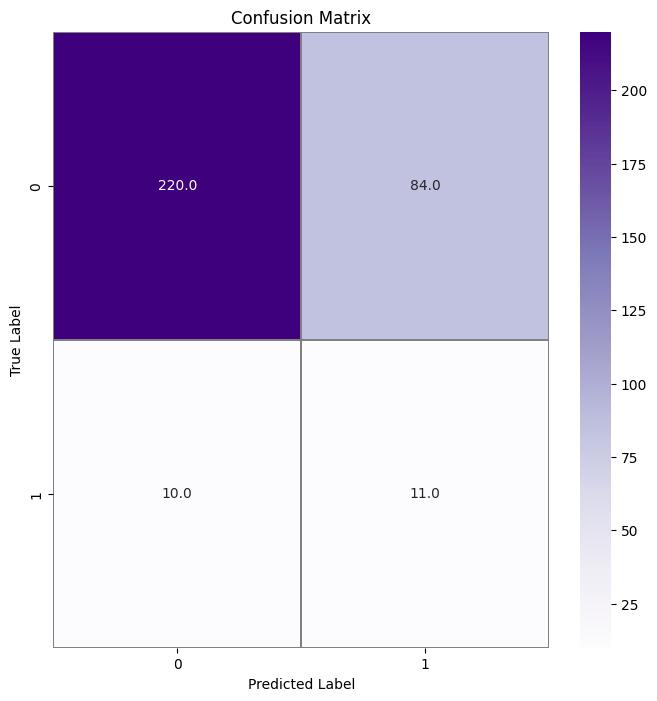

              precision    recall  f1-score   support

           0       0.96      0.72      0.82       304
           1       0.12      0.52      0.19        21

    accuracy                           0.71       325
   macro avg       0.54      0.62      0.51       325
weighted avg       0.90      0.71      0.78       325

          Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity   
0  CIR-SVC-AUG-no-CW  0.63                     0.19      0.71         0.52  \

   Specificity   PPV   NPV  PLR   NLR  
0         0.72  0.12  0.96  1.9  0.66  


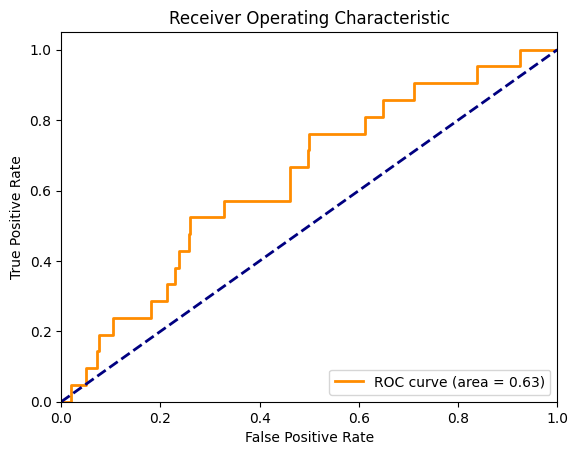

In [19]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name='CIR-SVC-AUG-no-CW')

## LOGISTIC REGRESSION

In [20]:
classifier = LogisticRegression(random_state=42, class_weight=class_weights_dict)
classifier.fit(X_train, y_train)

/Users/gcarballido/opt/miniconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 0.059920106524633865,
                                 1: 0.9400798934753661},
                   random_state=42)

Best threshold: 0.45 with F1-score: 0.12


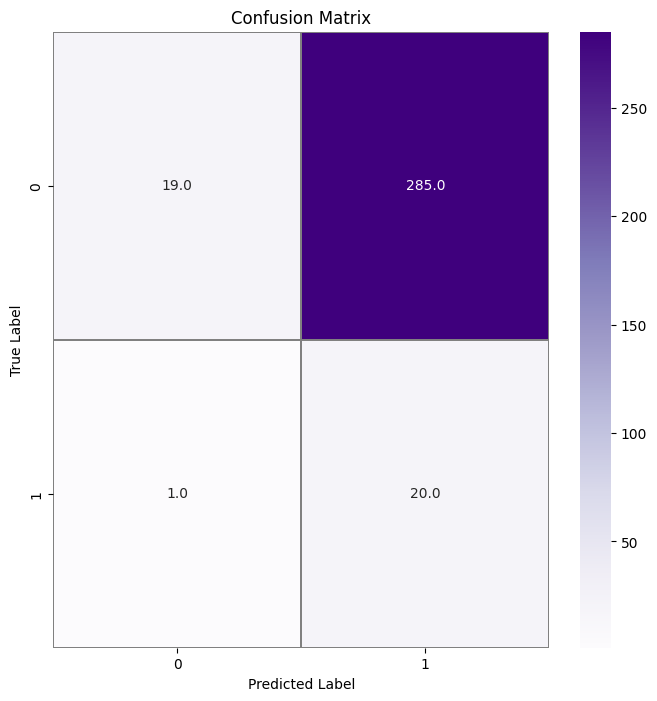

              precision    recall  f1-score   support

           0       0.95      0.06      0.12       304
           1       0.07      0.95      0.12        21

    accuracy                           0.12       325
   macro avg       0.51      0.51      0.12       325
weighted avg       0.89      0.12      0.12       325

   Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity   
0  CIR-LR-AUG  0.43                     0.12      0.12         0.95  \

   Specificity   PPV   NPV   PLR   NLR  
0         0.06  0.07  0.95  1.02  0.76  


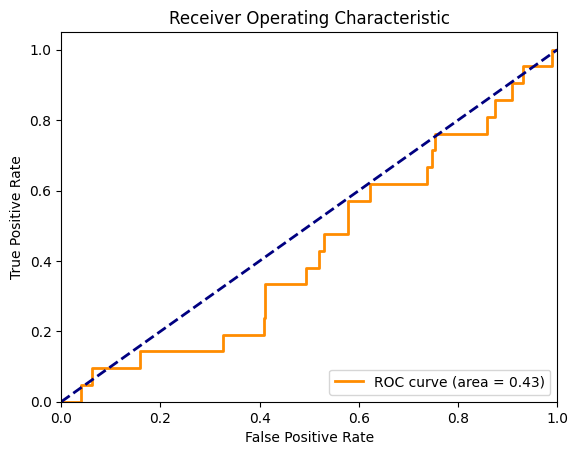

In [21]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name='CIR-LR-AUG')

In [22]:
# no class weights
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)

/Users/gcarballido/opt/miniconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

Best threshold: 0.43 with F1-score: 0.13


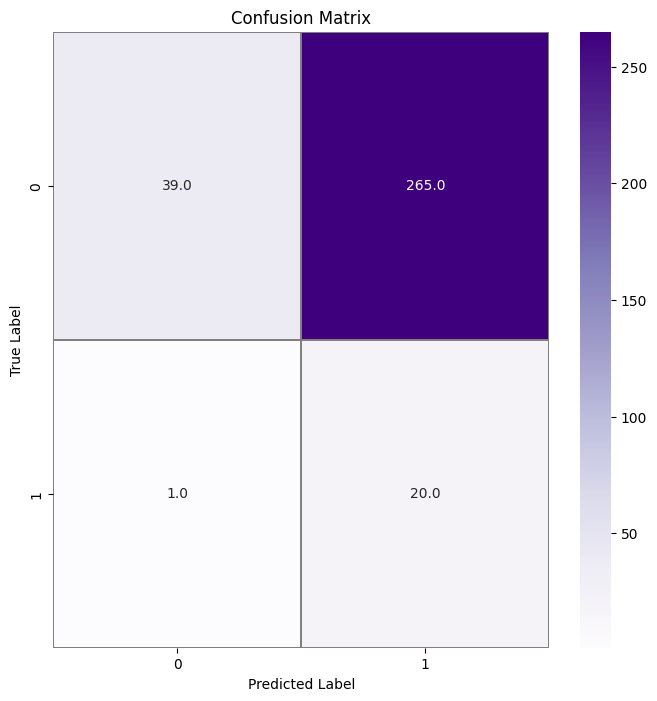

              precision    recall  f1-score   support

           0       0.97      0.13      0.23       304
           1       0.07      0.95      0.13        21

    accuracy                           0.18       325
   macro avg       0.52      0.54      0.18       325
weighted avg       0.92      0.18      0.22       325

         Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity   
0  CIR-LR-AUG-no-CW  0.47                     0.13      0.18         0.95  \

   Specificity   PPV   NPV   PLR   NLR  
0         0.13  0.07  0.98  1.09  0.37  


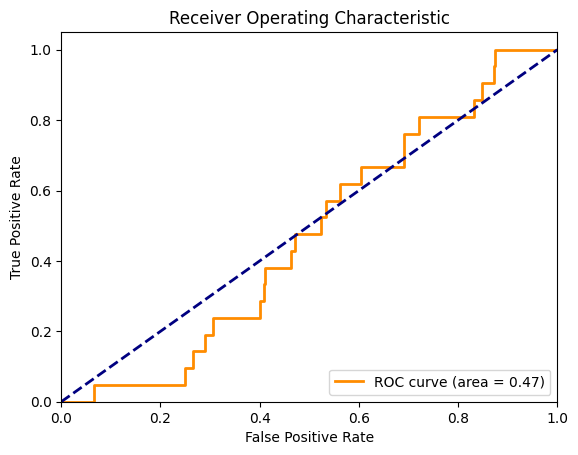

In [23]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name='CIR-LR-AUG-no-CW')

# Without Image Augmentation applied

In [51]:
X_train, y_train = load_data(train_folder)
X_validation, y_validation = load_data(validation_folder)
X_test, y_test = load_data(test_folder)

In [52]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform your string labels to numerical labels
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)
y_validation = label_encoder.fit_transform(y_validation)

In [53]:
# Merge X_test and X_validation
X_test = np.vstack((X_test, X_validation))
y_test = np.concatenate((y_test, y_validation))

In [54]:
# save data to upload to colab for later model tuning
np.savetxt("X_train_CIR_noaug.csv", X_train, delimiter=",")
np.savetxt("X_test_CIR_noaug.csv", X_test, delimiter=",")
np.savetxt("y_train_CIR_noaug.csv", y_train, delimiter=",")
np.savetxt("y_test_CIR_noaug.csv", y_test, delimiter=",")

In [28]:
# Extract class weights
from sklearn.utils.class_weight import compute_class_weight

# Convert the labels to a NumPy array
labels = np.array(y_train)

total_samples = len(labels)
class_labels, class_counts = np.unique(labels, return_counts=True)
#class_weights = total_samples / (len(class_labels) * class_counts)
class_weights = [1 - class_counts[0] / total_samples, 1 - class_counts[1] / total_samples]

# Create a dictionary for class weights
class_weights_dict = dict(zip(class_labels, class_weights))

#new_labels = {'healthy': 0, 'unhealthy': 1}

# Create a new dictionary with the renamed keys
#class_weights = {new_labels[key]: value for key, value in class_weights_dict.items()}

In [29]:
class_weights_dict

{0: 0.059920106524633865, 1: 0.9400798934753661}

In [30]:
sample_weights = [class_weights[label] for label in y_train]

## SVC

In [31]:
# Train a classifier (SVM in this case)
classifier = SVC(kernel='linear', C=1.0, random_state=42, probability=True, class_weight=class_weights_dict)
classifier.fit(X_train, y_train)

SVC(class_weight={0: 0.059920106524633865, 1: 0.9400798934753661},
    kernel='linear', probability=True, random_state=42)

Best threshold: 0.00 with F1-score: 0.12


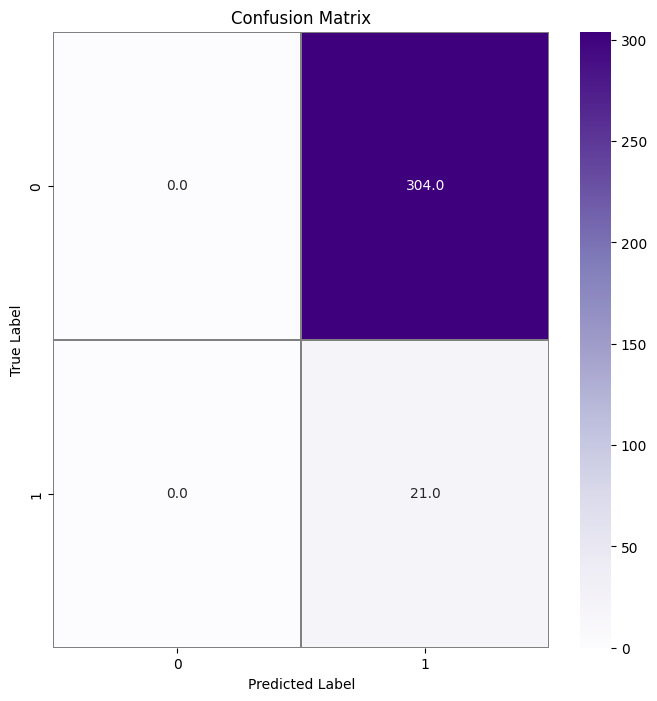

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       304
           1       0.06      1.00      0.12        21

    accuracy                           0.06       325
   macro avg       0.03      0.50      0.06       325
weighted avg       0.00      0.06      0.01       325

       Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity   
0  CIR-SVC-no-AUG  0.38                     0.12      0.06          1.0  \

   Specificity   PPV  NPV  PLR  NLR  
0          0.0  0.06  NaN  1.0  NaN  


/Users/gcarballido/opt/miniconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gcarballido/opt/miniconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gcarballido/opt/miniconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

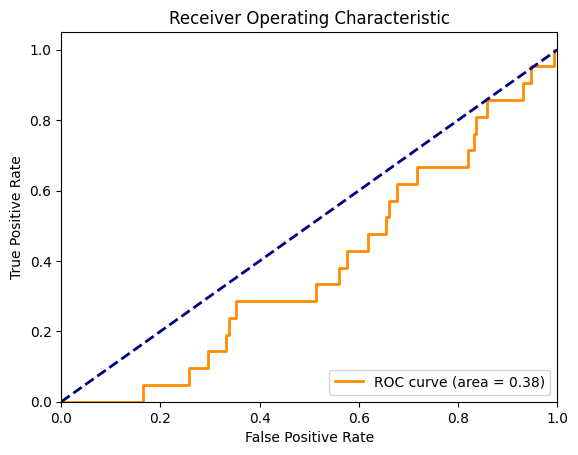

In [32]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name='CIR-SVC-no-AUG')

In [33]:
# no class weights
model_name = 'GLCM_SVC_no_CW_no_img_aug'

classifier = SVC(kernel='linear', C=1.0, random_state=42, probability=True)
classifier.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

Best threshold: 0.00 with F1-score: 0.12


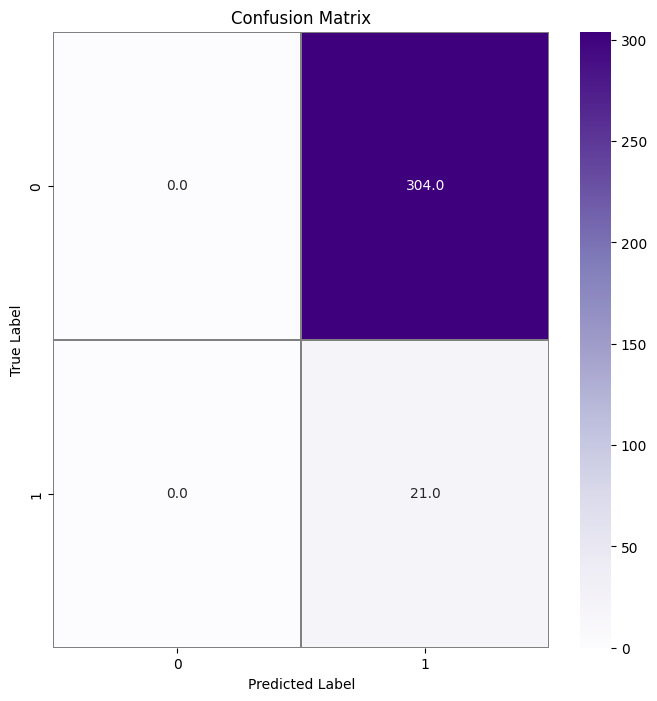

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       304
           1       0.06      1.00      0.12        21

    accuracy                           0.06       325
   macro avg       0.03      0.50      0.06       325
weighted avg       0.00      0.06      0.01       325

             Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity   
0  CIR-SVC-no-AUG-no-CW  0.47                     0.12      0.06          1.0  \

   Specificity   PPV  NPV  PLR  NLR  
0          0.0  0.06  NaN  1.0  NaN  


/Users/gcarballido/opt/miniconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gcarballido/opt/miniconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gcarballido/opt/miniconda3/envs/deeplearning/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

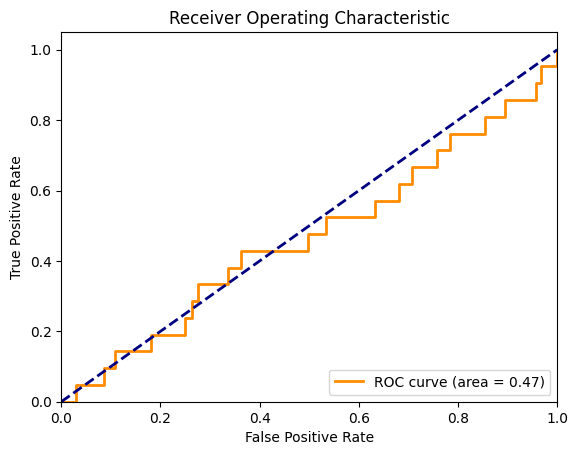

In [34]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name='CIR-SVC-no-AUG-no-CW')

## Logistic Regression

In [35]:
classifier = LogisticRegression(random_state=42, class_weight=class_weights_dict)
classifier.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.059920106524633865,
                                 1: 0.9400798934753661},
                   random_state=42)

Best threshold: 0.60 with F1-score: 0.17


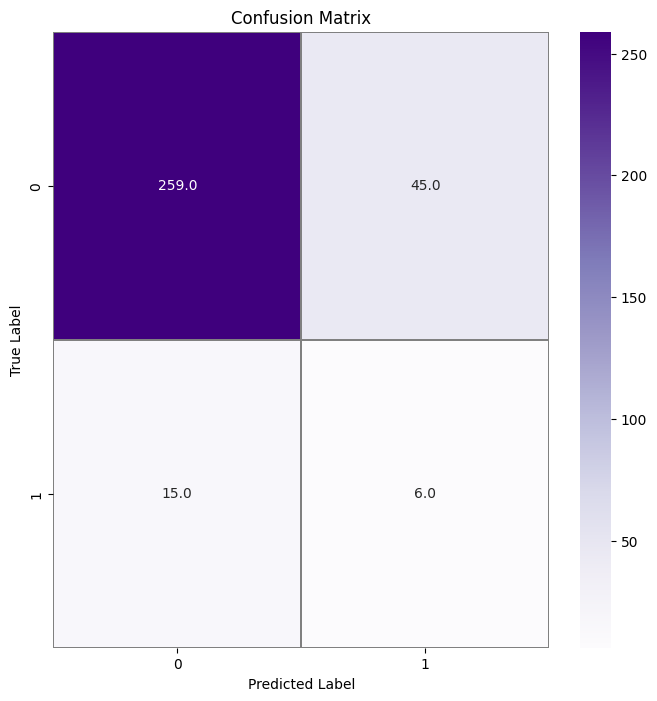

              precision    recall  f1-score   support

           0       0.95      0.85      0.90       304
           1       0.12      0.29      0.17        21

    accuracy                           0.82       325
   macro avg       0.53      0.57      0.53       325
weighted avg       0.89      0.82      0.85       325

      Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity   
0  CIR-LR-no-AUG  0.61                     0.17      0.82         0.29  \

   Specificity   PPV   NPV   PLR   NLR  
0         0.85  0.12  0.95  1.93  0.84  


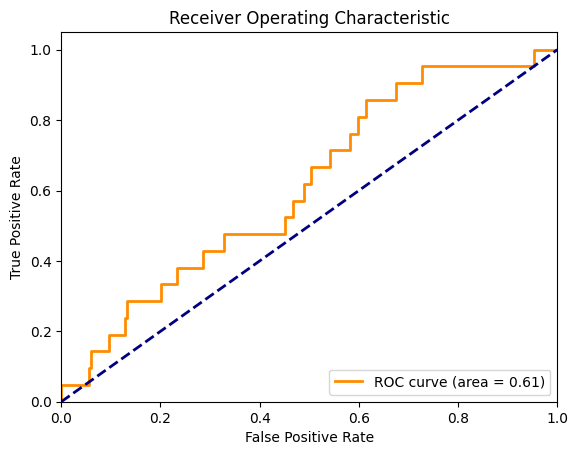

In [36]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name='CIR-LR-no-AUG')

In [37]:
# no class weights
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=42)

Best threshold: 0.11 with F1-score: 0.16


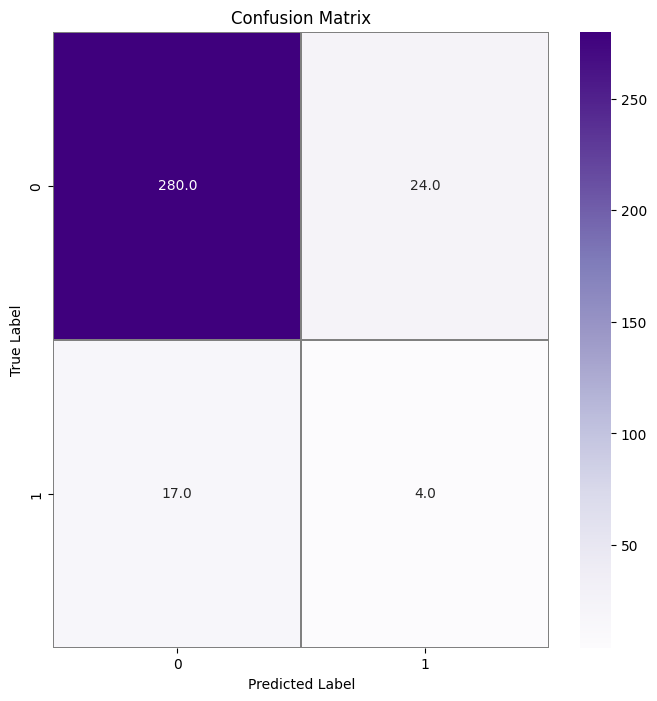

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       304
           1       0.14      0.19      0.16        21

    accuracy                           0.87       325
   macro avg       0.54      0.56      0.55       325
weighted avg       0.89      0.87      0.88       325

            Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity   
0  CIR-LR-no-AUG-no-CW  0.61                     0.16      0.87         0.19  \

   Specificity   PPV   NPV   PLR   NLR  
0         0.92  0.14  0.94  2.41  0.88  


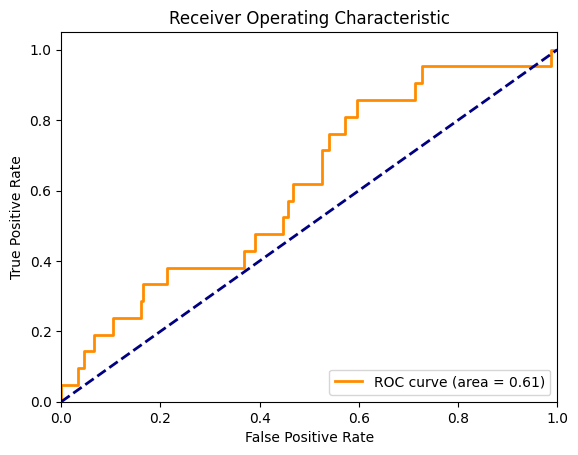

In [38]:
get_model_metrics(test_data=[X_test,y_test], model=classifier, model_name='CIR-LR-no-AUG-no-CW')